In [33]:
#Importing packages
import pandas as pd
import io
from math import sqrt
import matplotlib.pyplot as plt 
import numpy as np
from datetime import datetime
from scipy import stats
import math
from sklearn.metrics import mean_squared_error
from decimal import Decimal
import timeit

from concurrent.futures import ProcessPoolExecutor
import os

## Setting defaults for plots
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 400
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 30
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.linewidth'] = 2

In [23]:
def generate_random_weights(num):
    return np.random.exponential(1, num)

def weights_matrix(num, length):
    weights = [generate_random_weights(length) for _ in range(num)]
    return np.array(weights).T

def R(x,w): 
    # To store the required sum 
    s = 0; 
    n = len(x)
    for i in range(0,n): 
        # Add factorial of all the elements 
        s += math.lgamma(x[i]+1) * w[i];
        #s += math.log(math.factorial(x[i]))*w[i]; 
    return s

# For stepwise function plot
def mystep(x,y,z, ax=None, **kwargs):
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    X = np.c_[x[:-1],x[1:],x[1:]]
    Y = np.c_[y[:-1],y[:-1],np.zeros_like(x[:-1])*np.nan]
    Z = np.c_[z[:-1],z[:-1],np.zeros_like(x[:-1])*np.nan]
    plt.figure(figsize=(15,8))
    if not ax: ax=plt.gca()
    ax.plot(X.flatten(), Z.flatten(), **kwargs)
    return ax.plot(X.flatten(), Y.flatten(), **kwargs)

def Likelihood(theta, x, p=3, w=None):
    """
    Compute the (possibly weighted) log-likelihood of an AR(p) process with Gaussian noise.

    Parameters:
        theta (array): Parameter vector [phi_1, ..., phi_p, sigma2]
        x (array): Time series data
        p (int): Order of AR process
        w (array or None): Optional weights for each residual (length = len(x) - p)

    Returns:
        log_likelihood (float): The log-likelihood of the AR(p) model
    """
    phi = np.array(theta[:p])
    sigma2 = theta[p]

    if sigma2 <= 0:
        return -np.inf

    T = len(x)
    if T <= p:
        raise ValueError("Time series length must be greater than AR order p.")
    
    residuals = np.array([
        x[t] - np.dot(phi, x[t-p:t][::-1])
        for t in range(p, T)
    ])

    n = T - p

    # Default to equal weights if none provided
    if w is None:
        w = np.ones(n)
    else:
        w = w[:-p]

    log_density = -0.5 * np.log(2 * np.pi * sigma2) - 0.5 * residuals**2 / sigma2
    logL = np.sum(w * log_density)

    return logL

def MLE_estimator(x, p=3, w=None, return_stats=False):
    x = np.asarray(x)
    T = len(x)

    if T <= p:
        raise ValueError("Time series length must be greater than AR order p.")

    y = x[p:]
    X = np.column_stack([x[p - i - 1:T - i - 1] for i in range(p)])

    if w is None:
        w = np.ones(T)
    w = np.asarray(w)[p:]

    if len(w) != len(y):
        raise ValueError("Weights length does not match target vector length.")

    W = np.diag(w)
    XtWX = X.T @ W @ X
    XtWy = X.T @ W @ y

    phi_hat = np.linalg.solve(XtWX, XtWy)

    residuals = y - X @ phi_hat
    sigma2_hat = np.sum(w * residuals**2) / np.sum(w)

    if return_stats:
        return phi_hat, sigma2_hat, XtWX, XtWy, np.sum(w * residuals**2), np.sum(w)
    else:
        return np.append(phi_hat, sigma2_hat)



def fuse_AR_estimators(stats_list):
    """
    Fuse multiple AR(p) MLE estimators using sufficient statistics.

    Parameters:
    -----------
    stats_list : list of tuples
        Each tuple: (XtWX, XtWy, SSR, total_weight)

    Returns:
    --------
    fused_phi : array
        Combined AR(p) coefficients.
    fused_sigma2 : float
        Combined noise variance estimate.
    """
    S_X_total = None
    S_y_total = None
    SSR_total = 0
    weight_total = 0

    for XtWX, XtWy, SSR, weight in stats_list:
        if S_X_total is None:
            S_X_total = XtWX
            S_y_total = XtWy
        else:
            S_X_total += XtWX
            S_y_total += XtWy
        SSR_total += SSR
        weight_total += weight

    phi_fused = np.linalg.solve(S_X_total, S_y_total)
    sigma2_fused = SSR_total / weight_total

    return np.append(phi_fused, sigma2_fused)

def likelihoods(data, params_matrix, p=3, w=None):
    """
    Compute the log-likelihoods of an AR(p) process for multiple parameter sets.

    Parameters:
        params_matrix : array_like, shape (n_params, p+1)
            Each row contains [phi1, ..., phip, sigma] for one simulation
        data : array_like, shape (n,)
            Time series data as a 1D NumPy array
        p : int
            Order of the autoregressive process

    Returns:
        log_likelihoods : ndarray, shape (n_params,)
            Array of log-likelihoods for each parameter set
    """
    data = np.asarray(data)
    n = len(data)
    if n <= p:
        return np.full(len(params_matrix), -np.inf)

    # Lag matrix (X) and target vector (y)
    X = np.column_stack([data[p - i - 1 : n - i - 1] for i in range(p)])
    y = data[p:]

    params_matrix = np.atleast_2d(params_matrix)
    log_likelihoods = np.empty(params_matrix.shape[0])

    for i, params in enumerate(params_matrix):
        log_likelihoods[i] = Likelihood(params, data, p=p, w=w)
    return np.array(log_likelihoods).reshape(-1, 1).T


#Simplifying numpy notation
def plus(a,b,c=0,d=0,e=0,h=0,i=0,j=0,k=0, l=0):
    sum_of_all = np.add(a,np.add(b,np.add(c,np.add(d,np.add(e,np.add(h,np.add(i,np.add(j,np.add(k,l)))))))))
    return sum_of_all

def neg(a):
    neg_a = np.multiply(a,-1)
    return neg_a

def product(a,b,c=1,d=1,e=1,h=1,i=1,j=1):
    product_of_all = np.multiply(a,np.multiply(b,np.multiply(c,np.multiply(d,np.multiply(e,np.multiply(h,np.multiply(i,j)))))))
    return product_of_all

#Function for Confidence Interval
def norm_CI(data, alpha=0.95):
    n = len(data)
    m, se = np.mean(data, axis=1), np.std(data,axis=1)
    h = se * stats.norm.ppf((1+alpha)/2)
    return m,m-h, m+h

In [ ]:
repeat_sim = 10
dataset_number = 1
vec = np.repeat(dataset_number, repeat_sim)

count = 0
for h in vec:
    print(f"Running simulation: {h}")
    count += 1
    DT_N = pd.read_csv(f"Datasets/{dataset_number}.csv")
    Data_N = np.array(DT_N.N)
    AR_lags = 3

    if count == 1:
        plt.figure()
        plt.plot(DT_N.Date, DT_N.N, color='k')
        plt.tick_params(axis="x", labelsize=20, labelrotation=45)
        plt.tick_params(axis="y", labelsize=20)
        lengths_name = str(n_total)
        coeffs_name = "initial"
        filename = f"{dataset_number}_AR3_{lengths_name}_{coeffs_name}_data.png"

    start = timeit.default_timer()
    io = Data_N.shape[0]
    c = 1.35
    n_0 = 200
    I_0 = list(Data_N[max(0, io - n_0):io])
    alpha = 0.95
    num_sim = 10

    n_k_minus1 = n_0
    I_k_minus1 = I_0

    windows, MLEs, scaled_windows = [], [], []
    tests = 0

    for l in range(0, Data_N.shape[0]):
        try:
            start_step = timeit.default_timer()
            io = Data_N.shape[0] - l
            
            #arithmetic
            K = int(io/n_0)
            
            #geometric
            # K = max(0, math.ceil((math.log(io) - math.log(n_0)) / math.log(c)))
            
            I_0 = list(Data_N[max(0, io - n_0):io])
            I_k_minus1 = I_0
    
            for k in range(1, K + 1):
                try:
                    #arithmetic
                    n_k = (k+1)*n_0
                    n_k_plus1 = (k+2)*n_0
        
                    #geometric
                    # n_k = int(n_0 * c**k)
                    # n_k_plus1 = int(n_0 * c**(k + 1))
        
                    I_k = list(Data_N[max(0, io - n_k):io])
                    # print(f"I_k Size: {len(I_k)}")
                    I_k_plus1 = list(Data_N[max(0, io - n_k_plus1):io])
                    MLE_I_k_plus1 = MLE_estimator(I_k_plus1, AR_lags)
        
                    J = list(range(max(AR_lags + 1, io - n_k), io - n_k_minus1))
                    T, T_b = [], []
        
                    for i in J:
                       #New intervals and their estimators
                        A_k = np.array(Data_N[max(0,io-n_k_plus1):(i+1)])
                        B_k = np.array(Data_N[i+1:io])
                        MLE_A = MLE_estimator(A_k)
                        MLE_B = MLE_estimator(B_k)
        
                        # test statistics for this breakpoint and adding it to the list
                        T_I_k = Likelihood(MLE_A, A_k) + Likelihood(MLE_B, B_k) - Likelihood(MLE_I_k_plus1, I_k_plus1)
                        T.append(T_I_k)
        
                        ## Bootstrap procedure
                        #  Getting lengths of intervals
                        len_A = len(A_k) #length of A_k
                        len_B = len(B_k) #length of B_k
        
                        #generating weights and
                        #calculating estimators for the bootstrap intervals
                        weights_A = weights_matrix(num_sim,len_A)[:, 0]
                        MLEs_A_b= MLE_estimator(A_k, p=AR_lags, w=weights_A)
        
                        log_ratio_A= likelihoods(A_k, MLEs_A_b, w=weights_A)
                        log_ratio_A = log_ratio_A
        
        
                        weights_B = weights_matrix(num_sim, len_B)[:, 0]
                        MLEs_B_b= MLE_estimator(B_k, p=AR_lags, w=weights_B)
        
                        loglikes_B= likelihoods(B_k, MLEs_B_b, w=weights_B)
        
                        log_ratio_B = loglikes_B
        
                        phi_A, sigma_A, SX_A, Sy_A, SSR_A, W_A = MLE_estimator(A_k, p=AR_lags, w=weights_A, return_stats=True)
                        phi_B, sigma_B, SX_B, Sy_B, SSR_B, W_B = MLE_estimator(B_k, p=AR_lags, w=weights_B, return_stats=True)
                        MLE_p = fuse_AR_estimators([
                            (SX_A, Sy_A, SSR_A, W_A),
                            (SX_B, Sy_B, SSR_B, W_B)
                        ])
        
                        
                        loglikes_p1= likelihoods(A_k, MLE_p, w=weights_A)
                        log_ratio_p1 = loglikes_p1
        
                        loglikes_p2= likelihoods(B_k, plus(MLE_p,MLE_A,MLE_B), w=weights_B)
                        log_ratio_p2 = loglikes_p2
        
                        sup_term = log_ratio_p1 +log_ratio_p2
                        #Test statistic for bootstrap for this breakpoint
                        T_I_k_b = np.subtract(np.add(log_ratio_A,log_ratio_B),sup_term)
                        T_b.append(T_I_k_b)
                        tests= tests+1
        
                    if len(J) > AR_lags + 1:
                        BS_dist = np.max(T_b, axis=0)
                        # print(BS_dist)
                        if len(BS_dist) > 0 and np.all(BS_dist >= 0):
                            test_value = max(T)
                            q = np.quantile(BS_dist, alpha)
                            critical_value = math.sqrt(2 * max(q, 0))
                            print(f"[DEBUG] test_value={test_value}, critical_value={critical_value}, len(BS_dist)={len(BS_dist)}, len(I_k)={len(I_k)}")
                        else:
                            test_value = 0
                            critical_value = 1
                    else:
                        test_value = 0
                        critical_value = 1
                    
                    if test_value > critical_value:
                        print(f"Found break for point {l} window size: {len(I_k)}")
                        break
                    else:
                        continue
                except ValueError as e:
                    print(e)
                    print(f"[DEBUG] Interval too small for AR({AR_lags}) process")
                    continue
    
            if K == 0:
                I_k = I_0
            windows.append(len(I_k))
            MLE_I_k = MLE_estimator(I_k, AR_lags)
            MLEs.append(MLE_I_k)
            scaled_windows.append(len(I_k)  / io)
            stop_step = timeit.default_timer()
            print(f"Step number: {l}, time per step: {stop_step - start_step:.2f}, window size: {len(I_k)}")
        except ValueError as e:
            print(e)
            print(f"[DEBUG] Interval too small for AR({AR_lags}) process")
            continue

    stop = timeit.default_timer()
    print(f"Simulation number: {count}\nTime: {stop - start:.2f} seconds\nTotal tests: {tests}")

    MLEs.reverse()
    windows.reverse()
    scaled_windows.reverse()
    MLEs = np.array(MLEs)

    DT_N['windows_' + str(count)] = pd.Series(windows)
    DT_N['scaled_windows_' + str(count)] = pd.Series(scaled_windows)
    DT_N['MLEs_B_1' + str(count)] = pd.Series(MLEs[:, 0])
    DT_N['MLEs_B_2' + str(count)] = pd.Series(MLEs[:, 1])
    DT_N['MLEs_B_3' + str(count)] = pd.Series(MLEs[:, 2])
    DT_N['MLEs_sigma_2' + str(count)] = pd.Series(MLEs[:, 3])

    filename = f"Arithmetic/{n_0}/{count}_{dataset_number}_AR3_{lengths_name}_{coeffs_name}_data.csv"
    DT_N.to_csv(filename, index=False)


<h1>Combining the files</h1>

In [7]:
n_0 = 100
repeat_sim = 10
coeffs_name = "initial"
n_total = 1500
dataset_number = "1"
lengths_name = str(n_total)
filename_extra = f"_{dataset_number}_AR3_{lengths_name}_{coeffs_name}_data.csv"

# Getting names of all csv files
all_filenames=[]
for i in range(1,repeat_sim+1):
    filename = f"Arithmetic/{n_0}/" + str(i)+ filename_extra
    all_filenames.append(filename)
# Making a dataframe by concatinating name
df = pd.concat([pd.read_csv(f) for f in all_filenames ],axis=1)

#Deleting the duplicated date column
df = df.loc[:,~df.columns.duplicated()]
# Sorting the dataframe aphabatically
df = df.reindex(sorted(df.columns), axis=1)
df.to_csv(f'Arithmetic/{n_0}/combined_data.csv', index=False)

<h1>Constructing Confidence Intervals</h1>

In [8]:
filename = f'Arithmetic/{n_0}/combined_data.csv'
df= pd.read_csv(filename)
dates = df.Date

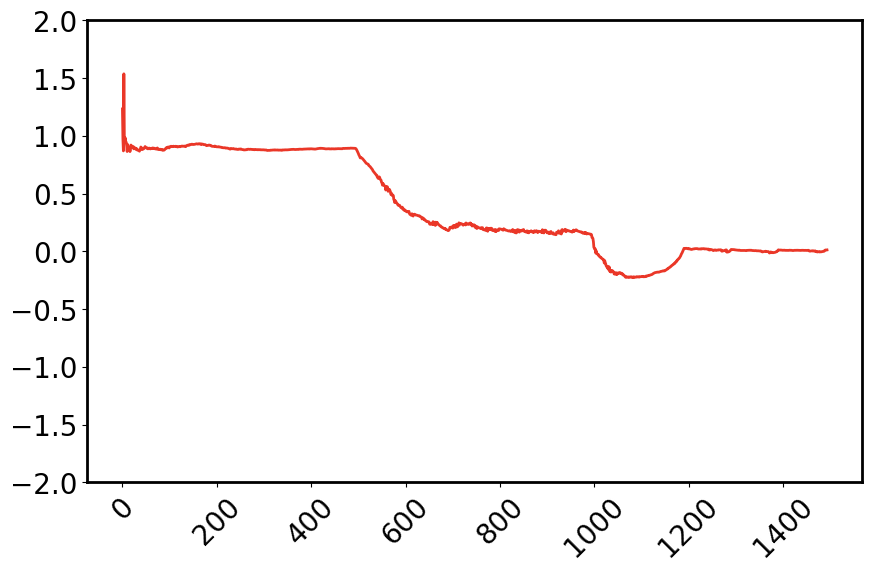

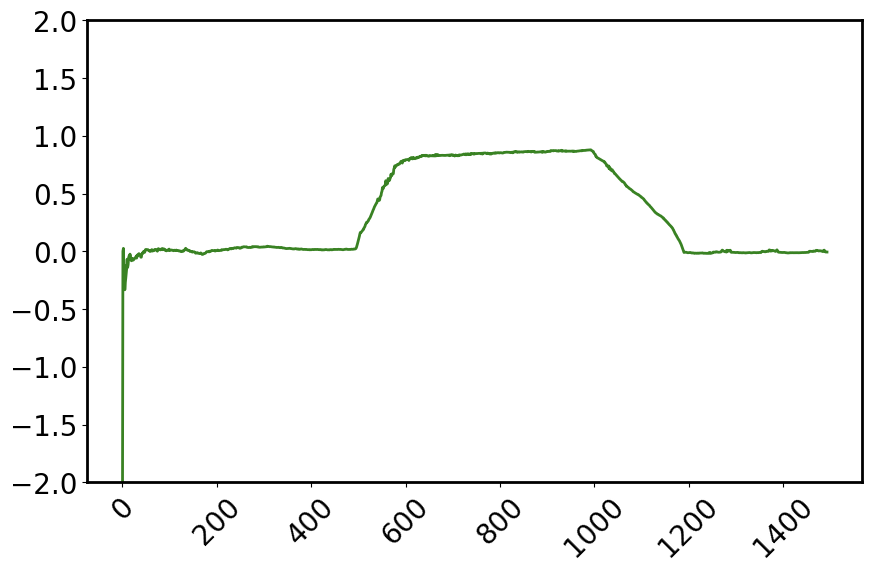

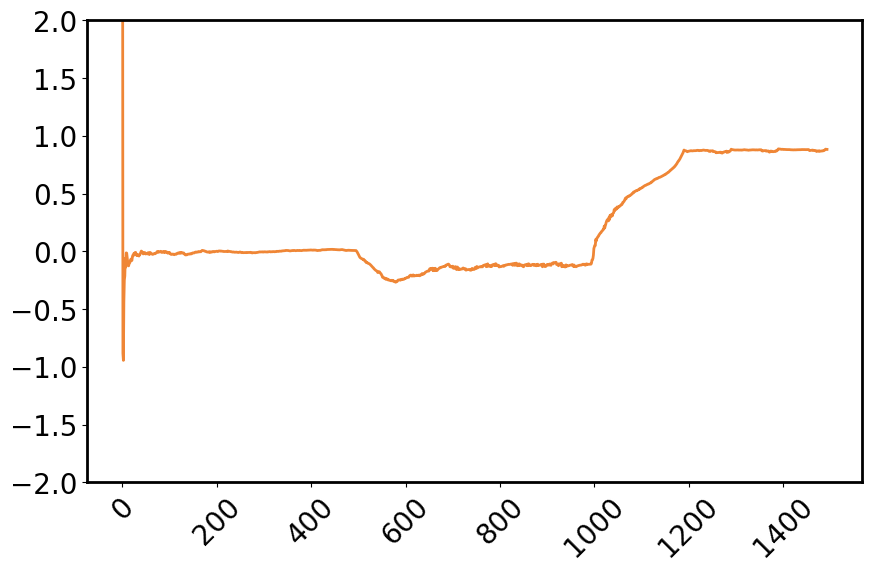

In [21]:
#CI plot
#Getting CIs for MLEs
colors = ["#EA3728", "#398223", "#EF8636"]
for beta in range(3):
    A= df.iloc[:,beta*repeat_sim+1:(beta+1)*repeat_sim+1]
    CI = norm_CI(A)
    mu = CI[0]
    lower = CI[1]
    upper = CI[2]
    plt.plot(dates,mu, color=colors[beta])
    # plt.plot(dates,upper, color=colors[beta], linestyle = '--', alpha=.30)
    # plt.plot(dates,lower, color=colors[beta], linestyle = '--', alpha=.30)
    plt.tick_params(axis="x", labelsize=20, labelrotation = 45)
    plt.tick_params(axis="y", labelsize=20)
    plt.ylim(-2, 2)
    filename = f"Arithmetic/{n_0}/B_{beta+1}_MLEs_confidence.png"
    plt.savefig(filename, transparent = True, bbox_inches="tight")
    plt.show()

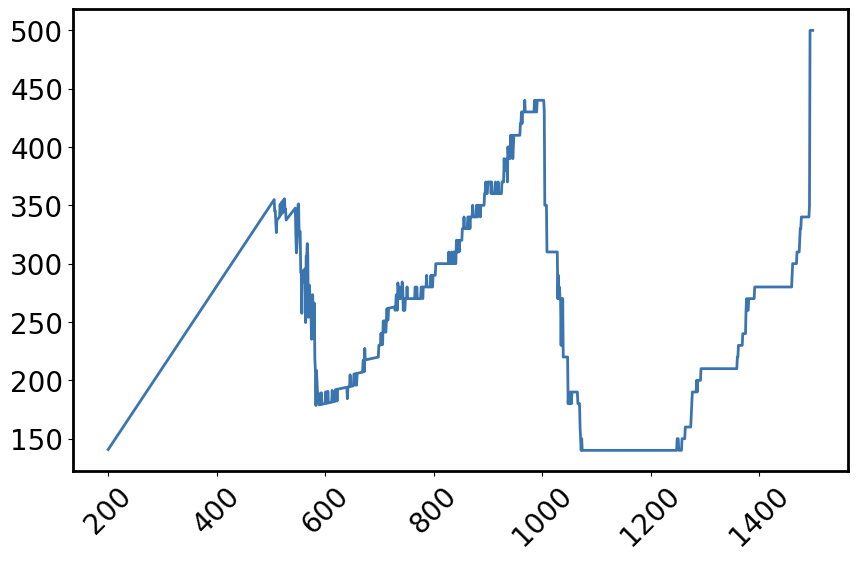

In [34]:
# Fetching windows data from dataframe
A= df.iloc[:,-repeat_sim:]

#Getting CIs
CI = norm_CI(A)
mu = CI[0]
lower = CI[1]
upper = CI[2]
#CI plot
plt.plot(dates, np.concatenate((np.repeat(np.nan, 200), mu[200:])), color='#3B75AF')
# plt.plot(dates,upper, color='b', linestyle = '--', alpha=.30)
# plt.plot(dates,lower, color='b', linestyle = '--', alpha=.30)
plt.tick_params(axis="x", labelsize=20, labelrotation = 45)
plt.tick_params(axis="y", labelsize=20)
plt.savefig(f"Arithmetic/{n_0}/window_size.png", transparent = True,  bbox_inches="tight")

mu.to_csv(f"Arithmetic/{n_0}/window_size.csv", header=['window'])

In [11]:
#Making a new column of MLEs in data 
col = df.loc[: , "MLEs_B_11":"MLEs_B_19"]
df['MLEs_B_1'] = col.mean(axis=1)

b2_col = df.loc[: , "MLEs_B_21":"MLEs_B_29"]
df['MLEs_B_2'] = b2_col.mean(axis=1)

b3_col = df.loc[: , "MLEs_B_31":"MLEs_B_39"]
df['MLEs_B_3'] = b3_col.mean(axis=1)

In [ ]:
DT_N = df
nop=1 #number of periods ahead to forecast 

# Initialize y values
y = [0, 0, 0]

# Simulate AR(3) process using MLEs from DataFrame
for t in range(3, len(df)):
    # print(y[t-1])
    y_t = (
        # 1 +
        df.loc[t, 'MLEs_B_11'] * y[t-1] +   # y_{t-1}
        df.loc[t, 'MLEs_B_21'] * y[t-2] +   # y_{t-2}
        df.loc[t, 'MLEs_B_31'] * y[t-3]     # y_{t-3}
        + df.loc[t, 'epsilon']
    )
    # print(df.loc[t, 'MLEs_B2'])
    y.append(y_t)


dates = df.Date
plt.plot(dates, DT_N.N)
plt.plot(dates,y, linestyle='-', color = 'r')

# Drop the first 3 values to match the DataFrame index
plt.tick_params(axis="x", labelrotation = 45)